# Translasso调试

In [1]:
from methods.our_method import Our_method
# from methods.trans_lasso import Trans_lasso
from methods.t_lasso import T_lasso
from methods.least_square import Least_square


from evaluator.evaluator import *
from evaluator.sample_generator import *
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import numpy as np
from methods.utils import *

In [2]:
from methods.estiminator import estiminator
import numpy as np
from sklearn.linear_model import Lasso
import time

# 这是一个联合估计器，使用的算法来自Transfer learning for high-dimensional linear regression: Prediction, estimation and minimax optimality
class Trans_lasso(estiminator):
    def __init__(self, n_features=0,s=0,L=0,instance=None):
        if instance is not None:
            super(Trans_lasso, self).__init__(instance.n_features,instance.s,instance.L)
        else:
            assert n_features>0 and s>0 and L>0
            super(Trans_lasso, self).__init__(n_features,s,L)
    
    #关于lambda的选择问题，原始论文中是这样进行的：
    #R:
    #cv.init<-cv.glmnet(X[ind.kA,], y.A, nfolds=8, lambda=seq(1,0.1,length.out=10)*sqrt(2*log(p)/length(ind.kA)))
    #lam.const <- cv.init$lambda.min/sqrt(2*log(p)/length(ind.kA))
    #lambda=lam.const*sqrt(2*log(p)/length(ind.kA)))$beta
    def fit(self, samples_packs,s=0,L=0):
        if s==0:
            s=self.s
        if L==0:
            L=self.L
        #Step1-划分训练集与测试集
        lamb=0.01
        model_num=len(samples_packs)-1
        if model_num==0:
            #直接lasso
            lasso=Lasso(alpha=0.01)
            lasso.fit(samples_packs[0].getX(),samples_packs[0].getY())
            #保留绝对值前s大个-?有意义吗？
            self.params=lasso.coef_
            return lasso.coef_,[],[],[]
        X0=samples_packs[0].getX()
        y0=samples_packs[0].getY()
        #按照7:3划分
        trainX=X0[:int(len(X0)*0.7)]
        trainy=y0[:int(len(y0)*0.7)]
        testX=X0[int(len(X0)*0.7):]
        testy=y0[int(len(y0)*0.7):]
        #Step2-生成GL下标集合
        #deltak=1/n_k*sum_{i=1}^{n_k}(x_i^T*y_i)-1/|X_0|*sum_{i=1}^{|X_0|}(x_i^T*y_i)
        R=[]
        t_star=20
        for i in range(len(samples_packs)-1):#最小二乘估计选择-?
            delta=np.dot(samples_packs[i+1].getX().T,samples_packs[i+1].getY())/len(samples_packs[i+1])-np.dot(trainX.T,trainy)/len(trainX)
            #将delta的绝对值从大到小排序，取前t_star个，其余置零作为新的delta
            delta[np.argsort(np.abs(delta))[:-t_star]]=0
            #delta的2范数的平方作为R
            R.append(np.linalg.norm(delta)**2)
        #从R中找出最小的L个元素对应的下标，作为GL的下标集合
        GL=np.argsort(R)[:self.L]
        #Step3-在GL中使用前1个、前2个、...、前L个模型分别进行Oracle Trans Lasso进行估计，获得beta1、beta2、...、betaL
        #Oracle Trans Lasso: 进行两步lasso估计
        #第一步：在所有的辅助模型中使用lasso进行估计，获得回归系数w
        #第二步：在目标模型中使用lasso进行估计，惩罚项为beta-w
        #这里使用sklearn中的lasso进行估计
        beta=[]
        for i in range(self.L):
            G=GL[:i+1]
            #第一步，在下标为G的辅助模型上同时使用lasso
            lasso=Lasso(alpha=0.01)
            infoX=[]
            infoy=[]
            for j in range(len(G)):
                infoX.append(samples_packs[G[j]+1].getX())
                # print(samples_packs[G[j]+1].getX().shape)
                infoy.append(samples_packs[G[j]+1].getY())
            infoX=np.concatenate(infoX)
            infoy=np.concatenate(infoy)
            # print(infoX.shape,infoy.shape)
            # lasso.fit(infoX,infoy)
            # w=lasso.coef_
            #改为使用最小二乘估计-?
            w=np.linalg.inv(infoX.T.dot(infoX)).dot(infoX.T).dot(infoy)
            assert len(w)==self.n_features
            #第二步，在目标模型上使用lasso估计beta，但惩罚项为beta-w
            # lasso=Lasso(alpha=0.01)
            trainyL=trainy-np.dot(trainX,w)
            # lasso.fit(trainX,trainyL)
            #改为岭回归-?
            beta_0=np.linalg.inv(trainX.T.dot(trainX)+lamb*np.eye(self.n_features)).dot(trainX.T).dot(trainyL)
            beta.append(beta_0+w)
        #Step4-使用beta1、beta2、...、betaL进行估计，获得beta
        #选择在测试集上表现最好的beta作为最终的beta
        from sklearn.metrics import mean_squared_error
        min_error=mean_squared_error(testy,np.dot(testX,beta[0]))
        min_index=0
        for i in range(self.L):
            error=mean_squared_error(testy,np.dot(testX,beta[i]))
            if error<min_error:
                min_error=error
                min_index=i
        #Step5-取绝对值前s大
        # beta[min_index][np.argsort(np.abs(beta[min_index]))[:-s]] = 0  
        self.params=beta[min_index]
        assert len(self.params)==self.n_features
        return beta[min_index],GL

In [3]:
n_features=16
n_samples=100
n_packs=101
s=16
# L_list=[2,4,8,12,16,20,24,28,32,36,40]
L_list=[2,4,8,12,16]
h_list=[2,6]
model_dic={"Trans_lasso":Trans_lasso(n_features,s,1),"lasso":T_lasso(n_features,s,1),"Least_square":Least_square(n_features,s,1)}

In [4]:
#L=2,4,8,12,16,20 -?没有做L=0的代码
#多次实验取平均
import multiprocessing
workers=multiprocessing.cpu_count()
result_list=[]
for h in [2,6]:
    result_list.append([])
    for L in tqdm(L_list):
    # for L in tqdm([2,4,8,12]):
        result_list[-1].append([])
        eval=evaluator(repeat_times=1,model_num=len(model_dic))
        for i in range(5):#选一个可以被workers整除的数
            sample_packs,coef_true=t22_eval(n_features,s,n_packs,n_samples,h,L)
            eval.append(model_dic,sample_packs,coef_true,s,L,False)
        eval.run(workers,False)
        result_list[-1][-1]=eval.result_list
#将result_list保存下来
result_list=np.array(result_list)
np.save('log/result_list5'+time.strftime("%m-%d", time.localtime())+'.npy',result_list)

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


In [5]:
result_list.shape

(2, 5, 3, 5)

In [6]:
result=np.mean(result_list,axis=3)
#将第二个轴和第三个轴交换
result=np.swapaxes(result,1,2)

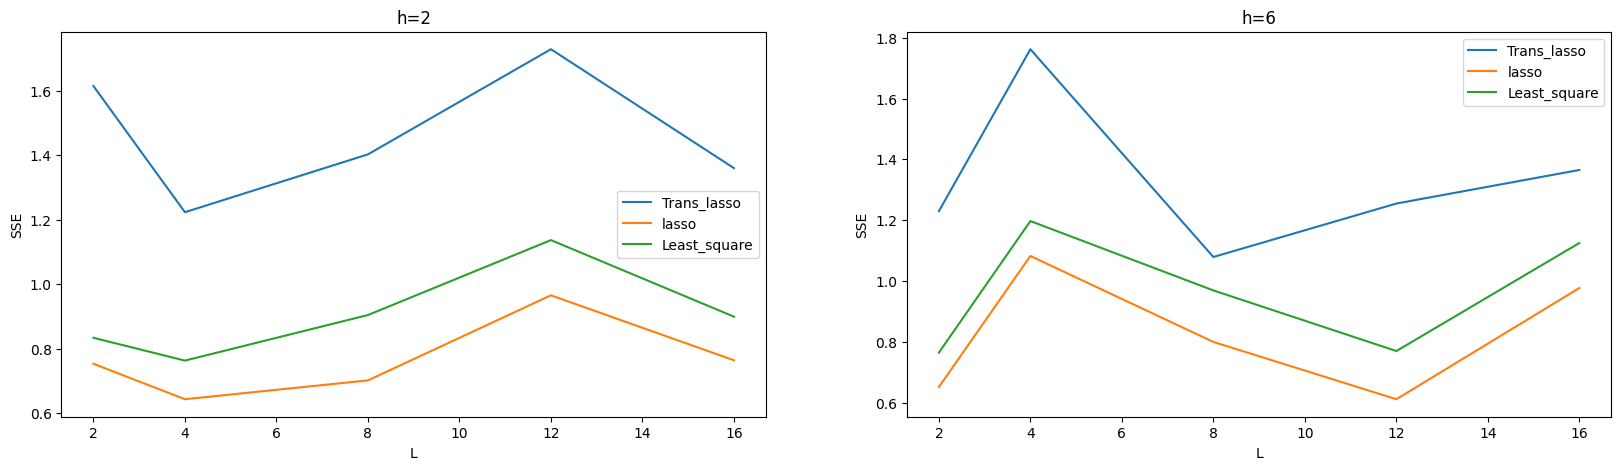

In [11]:
plot_graphs(model_dic,result,h_list,L_list)